In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath


In [2]:
dir_data='./data/'
dir_res='./result/'
dir_figs='./figs/'

In [3]:
#lire data
with open(dir_res+'cluster.txt', 'r') as clstr :
    cluster = np.array([int(i) for i in clstr.readline().replace('\n','')])[:-365]
    Regimes = clstr.readline().replace("'",'').replace('[','').replace(']','').split(',')

In [4]:
d1='1980-01-01T09'
d2='2019-12-31T18'

dates6 = pd.date_range(d1, d2, freq='D')
jours6 = np.any([dates6.day!=29,dates6.month!=2],axis=0)
dates6 = dates6[jours6]

data_tp = xr.open_dataset(dir_data+'tp_eur_19790101_20191231.nc').sel(time=dates6)

lat_t  = data_tp.latitude.values
lon_t  = data_tp.longitude.values
time_t  = data_tp.time.values

In [5]:
data_tp_anom = data_tp.groupby('time.dayofyear') - data_tp.groupby('time.dayofyear').mean('time')
tp_anom=data_tp_anom['tp'][15:-15]*1000

In [6]:
index_y=np.all([dates6 == dates6], axis=0)[15:-15]
cluster_t=cluster[index_y]

In [8]:
id_cluster1_t = np.any([cluster_t==0],axis=0)
mean_c1_anom_tp = tp_anom[id_cluster1_t,:,:].mean(axis=0)

In [9]:
cmap1='jet'
cmap2='RdBu_r'
cmap3='BrBG'
projection2=ccrs.NearsidePerspective(central_longitude=5.0, central_latitude=55.0)
bounds = [(-20, 30, 30, 80)]

def make_boundary_path(lon,lat):
    lons,lats=np.meshgrid(lon,lat)
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

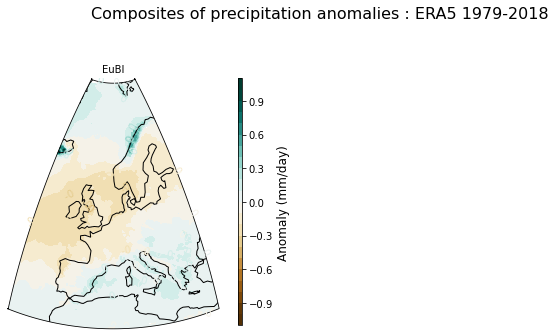

In [10]:
levs_tp_anom = np.linspace(-1, 1, 21)

fig = plt.figure(figsize=(15, 10))
fig.suptitle('Composites of precipitation anomalies : ERA5 1979-2018', fontsize=16)

ax = fig.add_subplot(2, 2, 1, projection=projection2)
plt.title(Regimes[0], fontsize=10, loc='center')
ax.coastlines()
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
boundary_path = make_boundary_path(lon_t, lat_t)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
cf = ax.contourf(lon_t, lat_t, mean_c1_anom_tp, levels=levs_tp_anom, 
                 cmap=cmap3, extend='both', transform=ccrs.PlateCarree())
ax.clabel(cf, inline=1, fmt='%4.0f', fontsize=10)
cb = fig.colorbar(cf, orientation='vertical', aspect=65, shrink=1, pad=0.05, extendrect='True')
cb.set_label('Anomaly (mm/day)', fontsize=12)

plt.show()

fig.savefig(dir_figs+'z500_eu_tp_composite'+'.jpeg', bbox_inches='tight')